In [83]:
from math import sqrt
import networkx as nx, numpy as np

In [84]:
#Makes a contact graph using the Barabasi-Albert algorithm to simulate social networks

#Inputs are nodes and edges (the number of nodes and edges)
# and cont_rate, which weights the fraction of time two nodes spend in contact

#Output:
#A graph where the none of the nodes are infected tested
#The edges simulate that the nodes came together a time t_start and stayed together for time t_tog

def make_cont_ba(nodes, cont_rate, edges=None):
    if not edges: #If you don't specify the number of edges for each node,
        #Choose the larger of 2 or the square root of the number of nodes
        edges=max(2,int(sqrt(nodes)/2))
    my_graph=nx.generators.random_graphs.barabasi_albert_graph(nodes, edges)
    time_start={e:np.random.rand() for e in my_graph.edges} #Random values for t_start
    nx.set_edge_attributes(my_graph, time_start, 't_start')
    time_tog={e:np.random.rand()*cont_rate for e in my_graph.edges} #Random values for t_tog weighted by cont_rate
    nx.set_edge_attributes(my_graph, time_tog, 't_tog')
    nx.set_node_attributes(my_graph, 0, 'tested')
    nx.set_node_attributes(my_graph, 0, 'infected')
    nx.set_node_attributes(my_graph, -1, 'source')
    nx.set_node_attributes(my_graph, -1, 'inf_time')
    return my_graph

In [85]:

#Simulates one node being infected where infection rate is inf_rate (if they spent time 1 together)
#Inputs a graph where that node was just infected by source (node) at inf_time
#Outputs a graph that simulates that node's infection other nodes
def sim_node_inf(graph, node, source, inf_time, inf_rate):
    new_graph=graph
    #Node received infection from source at inf_time
    new_graph.nodes[node]['infected']=1 
    new_graph.nodes[node]['source']=source
    new_graph.nodes[node]['inf_time']=inf_time 
    
    #The infection can spread to other nodes it interacted with after the infection time
    poss_spread=[n for n in new_graph.neighbors(node) if new_graph.edges[(node,n)]['t_start']>inf_time]
    print('Node {} infected by {} at time {}. Possible new infections:'.format(node, source, inf_time),
          ', '.join([str(n) for n in poss_spread]))
    
    for spread_node in poss_spread: #For each of these nodes
        inf_chance=new_graph.edges[(node,spread_node)]['t_tog']*inf_rate #Calculate the infection chance
        #The new infection is assumed to be the end of the source and infected nodes' time together
        new_inf_time=new_graph.edges[(node,spread_node)]['t_start']+new_graph.edges[(node,spread_node)]['t_tog']
        
        #If there is an infection (and the spread node isn't already infected
        if np.random.rand()<inf_chance and not new_graph.nodes[spread_node]['infected']:
            #Generate a new graph with that node as an infection source
            new_graph=sim_node_inf(new_graph, spread_node, node, new_inf_time, inf_rate)
            
    return new_graph

#Simulates infection of every node in a graph
#Inputs are a contact graph (such as from make_cont_ba), num_seed and num_tested as number
# of nodes seeded and tested, and inf_rate (infection rate if they spent time 1 together)
#Outputs is a graph with simulation for infections and tests
def sim_graph_inf(graph, num_seed, num_tested, inf_rate):
    new_graph=graph
    
    #Choose num_seed nodes to be the sources of infection
    seeds=np.random.choice(new_graph.nodes,num_seed, replace=False)
    for seed_node in seeds:
        new_graph.nodes[seed_node]['infected']=1
    
    #then simulate the resulting infections
    for source_node in seeds:
        new_graph=sim_node_inf(new_graph, source_node, -1, 0, inf_rate)
        
    #then choose num_tested to be tested
    for t_node in np.random.choice(graph.nodes,num_tested, replace=False):
        new_graph.nodes[t_node]['tested']=1
    return new_graph

Node 5 infected by -1 at time 0. Possible new infections: 0, 3
Node 0 infected by 5 at time 0.40695863940066934. Possible new infections: 3, 4, 7
Node 4 infected by 0 at time 0.8947001386023055. Possible new infections: 
Node 7 infected by 0 at time 0.878639361306604. Possible new infections: 
Node 3 infected by 5 at time 0.6539101910988941. Possible new infections: 1
Infected: [1, 0, 0, 1, 1, 1, 0, 1]
Tested:   [0, 1, 0, 0, 0, 0, 1, 0]


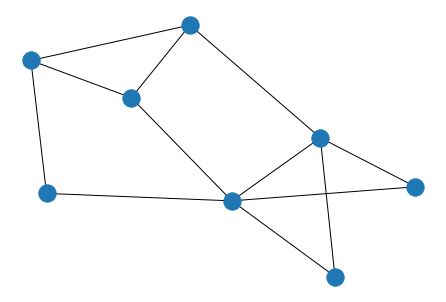

In [86]:
%matplotlib inline

#An example of an infection graph
test_graph=make_cont_ba(8, 0.1, edges=2)
inf_graph=sim_graph_inf(test_graph, 1, 2, 10)
print('Infected:', [inf_graph.nodes[node]['infected'] for node in inf_graph.nodes])
print('Tested:  ', [inf_graph.nodes[node]['tested'] for node in inf_graph.nodes])

nx.draw(inf_graph)

In [87]:
[(e[0],e[1],inf_graph.edges[e]['t_start'], inf_graph.edges[e]['t_tog']) for e in inf_graph.edges]

[(0, 2, 0.07459867551628718, 0.028221455693243594),
 (0, 3, 0.4539579982728512, 0.054639628417217825),
 (0, 4, 0.8166156393846177, 0.07808449921768784),
 (0, 5, 0.3312681027331309, 0.07569053666753842),
 (0, 7, 0.8176743867864155, 0.06096497452018852),
 (1, 2, 0.8034727118577868, 0.059494491107215525),
 (1, 3, 0.9808854610051452, 0.06456798705296637),
 (1, 6, 0.031749892160804594, 0.011283517024616175),
 (2, 6, 0.5134975708624057, 0.07652315803002827),
 (3, 4, 0.53513816112712, 0.010625587961915274),
 (3, 5, 0.562619135380297, 0.09129105571859716),
 (6, 7, 0.5441773742102713, 0.05598171881136288)]

In [89]:
import pandas as pd
source = []
destination = []
time_start = []
duration = []
for e in inf_graph.edges:
    source.append(e[0])
    destination.append(e[1])
    time_start.append(inf_graph.edges[e]['t_start'])
    duration.append(inf_graph.edges[e]['t_tog'])
    
df = pd.DataFrame({'source':source, 'destination':destination, 'time_start':time_start, 'duration':duration})
df.head(12)

,source,destination,time_start,duration
0,0,2,0.074599,0.028221
1,0,3,0.453958,0.054640
2,0,4,0.816616,0.078084
3,0,5,0.331268,0.075691
4,0,7,0.817674,0.060965
5,1,2,0.803473,0.059494
6,1,3,0.980885,0.064568
7,1,6,0.031750,0.011284
8,2,6,0.513498,0.076523
9,3,4,0.535138,0.010626


In [90]:
df = df.sort_values(by = 'time_start')  #Sort by when intital interaction starts

In [91]:
data = np.array(df)

In [92]:
#Maps time input to be normalized between angle 0 and pi 
#where 0 is no time duration, pi is "max" time
#Outputs angle

def theta(time): 
    norm = time*10      
    lower, upper = 0.00, np.pi
    theta = [lower + (upper - lower) * x for x in norm]
    return theta

In [93]:
times = []
for i in range(data.shape[0]):
    times.append(data[i,3])

times = np.array(times)
angles = theta(times)

for i in range(data.shape[0]):
    data[i,3] = angles[i]

In [94]:
import math
import pandas as pd
import numpy as np
import qiskit as q
from qiskit import Aer
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram


statevec_simulator = q.Aer.get_backend("statevector_simulator")
qasm_sim = q.Aer.get_backend('qasm_simulator')

def do_job(circuit):
    
    job = q.execute(circuit, backend=statevec_simulator)
    result = job.result()
    statevec = result.get_statevector()
    
    n_qubits = circuit.n_qubits
    circuit.measure([i for i in range(n_qubits)], [i for i in range(n_qubits)])
    
    qasm_job = q.execute(circuit, backend=qasm_sim, shots=1024).result()
    counts = qasm_job.get_counts()
    
    return statevec, counts

In [95]:
circuit = q.QuantumCircuit(8,8)      #Number of Nodes/Individuals

seed_nodes = [1,5,3]                 #Need to pull seed_nodes from function
for seed_node in seed_nodes:
    circuit.x(seed_node)             #Make seeds = |1> meaning initally infected
circuit.barrier()

In [96]:
for i in range(data.shape[0]):
    
#     print(data[i,0],data[i,1],data[i,2],data[i,3])
    circuit.cx(int(data[i,0]),int(data[i,1]))  #entangle nodes/individuals 
    circuit.rx(data[i,3],int(data[i,0]))       #rotate souce node by theta

circuit.barrier()

In [97]:
circuit.draw()

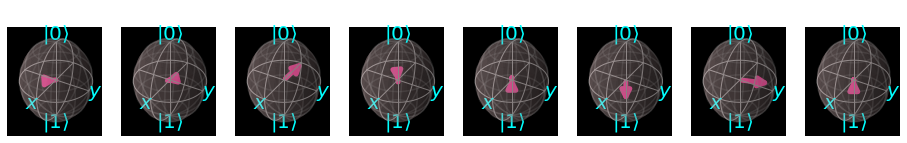

In [98]:
statevec, counts = do_job(circuit)
plot_bloch_multivector(statevec)

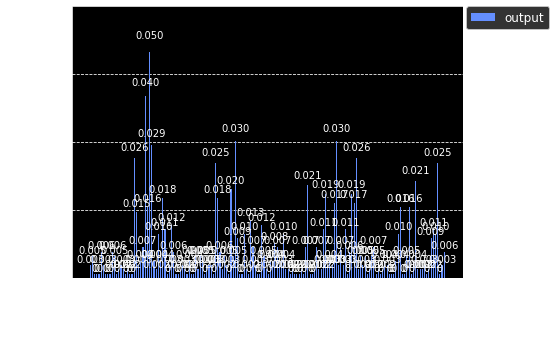

In [99]:
plot_histogram([counts], legend=['output'])